# Baseline Solutions for Predicting Olympic Medal Count

This notebook implements and analyzes two simple baseline predictive models for the following purposes:
 1. To see how "easy" this problem is to solve naively, so we have something to compare our more advanced Featuretools solution against
 2. To showcase the power of Featuretools' abstractions for code brevity and clarity
 3. To make a case for interpretable models
 
This notebook is meant as a companion notebook to FeaturetoolsPredictiveModelingSimple.ipynb. That notebook explains the concepts of Feature Engineering and Machine Learning in more depth.

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from featuretools.primitives import Count, NUnique
from ml import (score_predictions,
                bin_labels,
                TimeSeriesSplitByDate,
                fit_and_score)
from utils import (load_entityset,
                   get_feature_importances)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler
from IPython.display import display
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ROOT_DATA_FOLDER = os.path.expanduser("~/olympic_games_data")

# Load in data as a Featuretools Entityset

In [3]:
es = load_entityset()

# Load Labels From CSV
See GeneratingLabels.ipynb if you're interested in generating these labels yourself or learning how we define them

In [4]:
label_file = os.path.join(ROOT_DATA_FOLDER, "num_medals_by_country_labels.csv")
label_df = pd.read_csv(label_file,
                       parse_dates=['Olympics Date'],
                       usecols=['Number of Medals', 'Olympics Date', 'Country'],
                       encoding='utf-8')
# Sort by the date of the Olympics, and by the country (to maintain a consistent ordering)
label_df.sort_values(['Olympics Date', 'Country'], inplace=True)
label_df.head()

,Number of Medals,Olympics Date,Country
8,2,1896-06-29 00:00:00,AUS
9,5,1896-06-29 00:00:00,AUT
5,6,1896-06-29 00:00:00,DEN
10,11,1896-06-29 00:00:00,FRA
4,7,1896-06-29 00:00:00,GBR


In [5]:
# Just want the Country and time to compute features (we're removing the label column here)
cutoff_times = label_df[['Country', 'Olympics Date']]
# Code is the index of the "countries" entity in the entityset (short for Country Code)
cutoff_times = cutoff_times.rename(columns={'Country': 'Code'})

# Baseline 1

We will simply calculate the mean number of medals won by a country in the past, and use that as our prediction for the future.

This solution does not use any machine learning.

## Define features using Featuretools

In [6]:
# total number of medals per country
total_num_medals = Count(es['medals_won']['medal_id'], es['countries'])
# Number of unique Olympic Games each country has been present at
count_num_olympics = NUnique(es['countries_at_olympic_games']['Olympic Games ID'],
                             es['countries'])
# Mean number of medals = total medals across all previous Olympics / number of previous Olympics
mean_num_medals = (total_num_medals / count_num_olympics).rename("mean_num_medals")

## Compute features

In [7]:
feature_matrix = ft.calculate_feature_matrix([mean_num_medals],
                                             cutoff_time=cutoff_times,
                                             cutoff_time_in_index=True,
                                             verbose=True)
feature_matrix.tail()

Progress: 100%|██████████| 27/27 [00:17<00:00,  1.20s/cutoff time]


,,mean_num_medals
Code,time,
TUN,2012-06-29,1.25
TUR,2012-06-29,5.20
UKR,2012-06-29,17.00
USA,2012-06-29,71.20
UZB,2012-06-29,3.50


### Now as a comparison, let's compute the same values without Featuretools

It's a bit complicated because for each (Country, Olympics Date) combo, we have to compute the average number of medals *prior* to that date. The very first Olympics for each country would thus have a `np.nan` value for this average, since there is no data prior to that point.

Therefore, our workflow is to prepend an additional row for each country for the Olympics prior to its first entry (with a `nan` for the number of medals won), and then add 4 years to each row of the whole DataFrame. Then we can groupby the "Country" and use the Pandas expanding mean function to calculate the historical mean from all of the previous medals won by a Country.

In [9]:
indexers = ['Olympics Date', 'Country']
avg_num_medals = label_df

def add_years(dt, num):
    year = dt.year + num
    return pd.Timestamp(year=year, month=dt.month, day=dt.day)

# Find the minimum date for each and subtract 4 years
prev_olympics = (avg_num_medals.groupby('Country')['Olympics Date']
                               .min()
                               .apply(lambda df: add_years(df, -4))
                               .to_frame()
                               .reset_index(drop=False))
# Add these rows in and resort
avg_num_medals = (avg_num_medals.append(prev_olympics, ignore_index=True)
                                .sort_values(indexers))
# Now add 4 years to the date so that when we take the expanding_mean(),
# we leave out the number of medals won at the current olympics
avg_num_medals['Olympics Date'] = avg_num_medals['Olympics Date'].apply(
    lambda df: add_years(df, 4))

avg_num_medals = avg_num_medals.set_index(indexers)
mean_num_medals_over_time = (avg_num_medals.groupby(level='Country')
                                           .expanding()
                                           .mean()
                                           .groupby(level='Country')
                                           .apply(lambda df: df.iloc[:-1])
                                           .reset_index(drop=True, level=0)
                                           .reset_index(drop=False, level=[0, 1])
                                           .sort_values(indexers)
                            )[indexers + ['Number of Medals']]
mean_num_medals_over_time = mean_num_medals_over_time[
    mean_num_medals_over_time['Olympics Date'] < pd.Timestamp('1/1/2016')]

mean_num_medals_over_time.tail()

,Olympics Date,Country,Number of Medals
Country,,,
TUN,2012-06-29,TUN,1.25
TUR,2012-06-29,TUR,5.20
UKR,2012-06-29,UKR,17.00
USA,2012-06-29,USA,71.20
UZB,2012-06-29,UZB,3.50


## Sanity check

Taking the expanding mean of the labels should produce the same result, with an additional value at the end for the most recent Olympics

In [10]:
display(label_df[label_df['Country'] == 'USA']['Number of Medals'].expanding().mean().tail(6))
display(feature_matrix.loc['USA'].tail())

676     72.476190
730     72.136364
792     71.695652
882     71.375000
936     71.200000
1021    70.769231
Name: Number of Medals, dtype: float64

,mean_num_medals
time,
1996-06-29,72.476190
2000-06-29,72.136364
2004-06-29,71.695652
2008-06-29,71.375000
2012-06-29,71.200000


Some things to note:
1. We saved a lot of hard-to-read code using Featuretools.
2. The custom code was much faster. This is a known problem- Featuretools is an extremely powerful general purpose tool. It trades some performance for generality, ease of use, clean self-documenting code, and fewer chances for errors. If this bothers you and you'd like to help work on performance, please feel free to [contribute](https://github.com/featuretools/featuretools)!

### Now let's see how well this simple predictor does

In [11]:
# Countries that didn't take part in the previous olympics have default nan values in the dataframe
# Set them to the mean number of medals for that year
baseline1 = feature_matrix.copy()
null_predictions = baseline1['mean_num_medals'].isnull()
means = (baseline1.groupby(level='time')['mean_num_medals'].mean().to_frame())
baseline1[null_predictions] = (baseline1[null_predictions].drop(['mean_num_medals'], axis=1).join(means))

# Fill the 1896 olympics with 0 since we have no data to go off of
baseline1.fillna(0, inplace=True)
baseline1 = baseline1['mean_num_medals']
baseline1.head(20)

Code  time               
AUS   1896-06-29 00:00:00     0.0
AUT   1896-06-29 00:00:00     0.0
DEN   1896-06-29 00:00:00     0.0
FRA   1896-06-29 00:00:00     0.0
GBR   1896-06-29 00:00:00     0.0
GER   1896-06-29 00:00:00     0.0
GRE   1896-06-29 00:00:00     0.0
HUN   1896-06-29 00:00:00     0.0
SUI   1896-06-29 00:00:00     0.0
USA   1896-06-29 00:00:00     0.0
ZZX   1896-06-29 00:00:00     0.0
AUS   1900-06-29              2.0
AUT   1900-06-29              5.0
BEL   1900-06-29              7.4
BOH   1900-06-29              7.4
CAN   1900-06-29              7.4
CUB   1900-06-29              7.4
DEN   1900-06-29              6.0
ESP   1900-06-29              7.4
FRA   1900-06-29             11.0
Name: mean_num_medals, dtype: float64

In [12]:
y = label_df['Number of Medals'].values
y_binary = (y >= 10).astype(int)
binned_labels, bins = bin_labels(label_df['Number of Medals'], [2, 6, 10, 50])
y_binned = binned_labels.values

# Time-based cross-validation (for each Olympics starting in 1960, use all historical data in past)
splitter = TimeSeriesSplitByDate(dates=label_df['Olympics Date'],
                                 earliest_date=pd.Timestamp('1/1/1960'))

In [13]:
pd.Series(y_binary).value_counts()

0    753
1    312
dtype: int64

In [14]:
binned_labels.value_counts()

[2.0,6.0)      366
[10.0,50.0)    264
<2.0           246
[6.0,10.0)     141
>=50.0          48
dtype: int64

In [15]:
predictions = baseline1
scores_over_time = score_predictions(splitter,
                                     predictions,
                                     y,
                                     y_binary,
                                     y_binned)
for scoring_func, scores in scores_over_time.items():
    print "mean %s score: %.2f +/- %.2f" % (scoring_func,
                                            np.mean(scores),
                                            np.std(scores))

mean f1 score: 0.70 +/- 0.06
mean mse score: 91.79 +/- 69.90
mean f1_micro score: 0.48 +/- 0.07
mean r2 score: 0.72 +/- 0.10
mean roc_auc score: 0.79 +/- 0.04


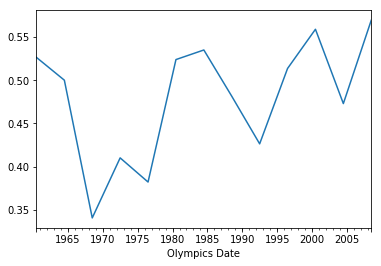

In [16]:
dates = splitter.dates.drop_duplicates()
dates = dates[dates['Olympics Date'] >= pd.Timestamp('1/1/1960')][:-1]['Olympics Date']
pd.Series(scores_over_time['f1_micro'], index=dates).plot()

## Quick analysis

Our AUC (a standard metric for binary classification, with 1.0 as a perfect score) is already very good.

We get 0.79 with no machine learning at all.

Our lowest interpretable score is the binned classifaction score: f1_micro, an f1 score averaged across each independent training example, also with a maximum of 1.0.
(Sci-kit Learn has a good [explanation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) of this metric)

Since we have no good way of knowing what a good "Mean Square Error" is for the regression case of the problem, we'll refer back to the binned case for an example of the hardest version of this problem.

Also, looking at the graph of scores over time, it seems our average gets better over time, albeit with large spikes for certain years. We can maybe attribute this to better averaging over time, while the model is very sensitive to changes in particular Olympic years (boycotts that happened, rule changes, etc.) .

# Baseline 2: Simple Machine Learning

Now we'll add some basic machine learning and see how much better we do. The plan is to provide the machine learning algorithm the information on the medals won for each country in *each* Olympics Year.

This means that we'll have a feature for each Olympics year, and for each (Country, Olympics year) training example, we'll first end up with all the values for *future* Olympics years as `nan`. We'll then make sure all these `nan` values end up as zero.

In [17]:
# Baseline 2
olympic_id = ft.Feature(es['countries_at_olympic_games']['Olympic Games ID'],
                        es['medals_won'])
num_medals_each_olympics = [
    Count(es['medals_won']['medal_id'], es['countries'],
          where=olympic_id == i).rename("num_medals_olympics_{}".format(i))
    for i in es.get_all_instances('olympic_games')[:-1]
]
feature_matrix = ft.calculate_feature_matrix(num_medals_each_olympics,
                                             cutoff_time=cutoff_times,
                                             cutoff_time_in_index=True,
                                             verbose=True)

Progress: 100%|██████████| 27/27 [00:25<00:00,  1.52s/cutoff time]


In [18]:
feature_matrix.head(10)

,,num_medals_olympics_0,num_medals_olympics_1,num_medals_olympics_2,num_medals_olympics_3,num_medals_olympics_4,num_medals_olympics_5,num_medals_olympics_6,num_medals_olympics_7,num_medals_olympics_8,num_medals_olympics_9,...,num_medals_olympics_16,num_medals_olympics_17,num_medals_olympics_18,num_medals_olympics_19,num_medals_olympics_20,num_medals_olympics_21,num_medals_olympics_22,num_medals_olympics_23,num_medals_olympics_24,num_medals_olympics_25
Code,time,,,,,,,,,,,,,,,,,,,,,
AUS,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUT,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEN,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBR,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GER,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GRE,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HUN,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SUI,1896-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Without featuretools
Note that here we default to np.nan instead of 0.0


Again, notice how much more code we have to write, how much less readable it it, but also that it is definitely faster for this simple case with small amounts of data.

In [19]:
fm_columns = []
all_countries = label_df[['Country']].drop_duplicates()
dates = label_df['Olympics Date'].drop_duplicates().sort_values()[:-1]
for i, date in enumerate(dates):
    at_date = label_df[label_df['Olympics Date'] == date]
    after_date = label_df[label_df['Olympics Date'] > date]
    after_date = after_date[['Olympics Date', 'Country']]
    num_medals_at_date = after_date.merge(at_date[['Country', 'Number of Medals']],
                                          on='Country', how='outer')
    num_medals_at_date = (num_medals_at_date.set_index('Country')
                                            .set_index('Olympics Date',
                                                       append=True))
    num_medals_at_date.rename(
        columns={'Number of Medals': 'num_medals_olympics_{}'.format(i)},
        inplace=True)
    fm_columns.append(num_medals_at_date)
baseline2_fm = (pd.concat(fm_columns, axis=1)
                  .sort_index(level='Olympics Date'))
baseline2_fm['label'] = (label_df.set_index('Country')
                                 .set_index('Olympics Date',
                                            append=True)['Number of Medals'])
baseline2_fm.head(10)

,,num_medals_olympics_0,num_medals_olympics_1,num_medals_olympics_2,num_medals_olympics_3,num_medals_olympics_4,num_medals_olympics_5,num_medals_olympics_6,num_medals_olympics_7,num_medals_olympics_8,num_medals_olympics_9,...,num_medals_olympics_17,num_medals_olympics_18,num_medals_olympics_19,num_medals_olympics_20,num_medals_olympics_21,num_medals_olympics_22,num_medals_olympics_23,num_medals_olympics_24,num_medals_olympics_25,label
Country,Olympics Date,,,,,,,,,,,,,,,,,,,,,
AHO,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ALG,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
ANZ,NaT,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
BAH,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
BER,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOH,NaT,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BWI,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHI,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [20]:
X = feature_matrix.values

# Machine Learning

Now we'll build some simple machine learning pipelines using this feature matrix. Actually, we'll use the same simple pipeline that we use in the Featuretools example with DFS features in FeaturetoolsPredictiveModelingSimple.ipynb.

This is to make for better comparisons.

In [21]:
# Build Machine Learning Pipelines

pipeline_preprocessing = [("imputer",
                           Imputer(missing_values='NaN', strategy="mean", axis=0)),
                          ("scaler", RobustScaler(with_centering=True))]

regression_models = {
        'linear_regression': LinearRegression(),
        'rf_regression': RandomForestRegressor(n_estimators=100, n_jobs=-1),
}
classification_models = {
        'logistic_regression': LogisticRegression(),
        'rf_clf': RandomForestClassifier(n_estimators=100, n_jobs=-1),
}

In [22]:
for name, model in regression_models.items():
    pipeline = Pipeline(pipeline_preprocessing + [(name, model)])
    scores = fit_and_score(X, y, splitter, pipeline, _type='regression')
    print "Regression model %s" % name
    r2_scores = scores['r2']
    mse_scores = scores['mse']
    print "  R2 mean score:  %.2f +/- %.2f" % (r2_scores.mean(),
                                               r2_scores.std())
    print "  MSE mean score:  %.2f +/- %.2f" % (mse_scores.mean(),
                                                mse_scores.std())


Regression model linear_regression
  R2 mean score:  0.50 +/- 0.19
  MSE mean score:  144.43 +/- 79.70
Regression model rf_regression
  R2 mean score:  0.78 +/- 0.15
  MSE mean score:  69.85 +/- 56.42


In [23]:
for name, model in classification_models.items():
    pipeline = Pipeline(pipeline_preprocessing + [(name, model)])
    scores = fit_and_score(X, y_binary, splitter, pipeline, _type='classification')
    binned_scores = fit_and_score(X, y_binned, splitter, pipeline, _type='classification')
    print "Classification model %s" % name
    roc_auc_scores = scores['roc_auc']
    f1_scores = scores['f1']
    f1_micro_scores = binned_scores['f1_micro']
    print "  AUC mean score:  %.2f +/- %.2f" % (roc_auc_scores.mean(),
                                                roc_auc_scores.std())
    print "  F1 mean score:  %.2f +/- %.2f" % (f1_scores.mean(),
                                               f1_scores.std())
    print "  Binned F1 (micro averaged) mean score:  %.2f +/- %.2f" % (f1_micro_scores.mean(),
                                                                       f1_micro_scores.std())



Classification model logistic_regression
  AUC mean score:  0.87 +/- 0.05
  F1 mean score:  0.72 +/- 0.08
  Binned F1 (micro averaged) mean score:  0.51 +/- 0.07
Classification model rf_clf
  AUC mean score:  0.93 +/- 0.03
  F1 mean score:  0.81 +/- 0.08
  Binned F1 (micro averaged) mean score:  0.60 +/- 0.09


# Compare Baseline 2 with Baseline 1

  1. Algorithm Choice

        The choice of classifier/regressor matters with these simple features. Using a Random Forest gives significantly higher scores when compared to the simpler LinearRegression and LogisticRegression models. LinearRegression actually performs much worse at the regression task compared to our simple baseline 1, which just predicted the average number of medals seen so far for each country.

  2. 2-class vs. Multiclass

      The multiclass problem is much harder (and so the regression problem should be much harder too, though that's hard to quantify from the regression error metrics). The micro-averaged F1 for the multiclass was much worse than the binary F1. This is not a perfect comparison, but given that our class distribution is relatively even, and the fact that the score is almost 50% worse means there's probably some merit in making the comparison.

  3. Binary problem is easy

      We get >.9 AUC using these very simple features, so instead of optimizing for predictive accuracy with complex features, we should probably care more about finding interesting explanatory features.

## The case for interpretability

As you can see below, the features we used provide no deeper insight into the problem. We don't know what math the underlying algorithms are using to translate these numbers into predictions, and the importance of the number of medals won in a particular year doesn't help us very much as humans trying to understand the problem.

In [24]:
feature_imps_by_time = get_feature_importances(pipeline, feature_matrix,
                                               pd.Series(y_binary), splitter)

In [25]:
for date, fi in sorted(feature_imps_by_time.items(), key=lambda x: x[0]):
    print "Test year: %s" % date.year
    print "Top 10 feats:"
    for f in fi['Feature'][:10]:
        print "   ", f

Test year: 1964
Top 10 feats:
    num_medals_olympics_3
    num_medals_olympics_4
    num_medals_olympics_6
    num_medals_olympics_0
    num_medals_olympics_1
    num_medals_olympics_7
    num_medals_olympics_8
    num_medals_olympics_2
    num_medals_olympics_5
    num_medals_olympics_9
Test year: 1968
Top 10 feats:
    num_medals_olympics_3
    num_medals_olympics_4
    num_medals_olympics_0
    num_medals_olympics_6
    num_medals_olympics_1
    num_medals_olympics_12
    num_medals_olympics_7
    num_medals_olympics_8
    num_medals_olympics_11
    num_medals_olympics_9
Test year: 1972
Top 10 feats:
    num_medals_olympics_3
    num_medals_olympics_0
    num_medals_olympics_1
    num_medals_olympics_4
    num_medals_olympics_12
    num_medals_olympics_6
    num_medals_olympics_8
    num_medals_olympics_7
    num_medals_olympics_11
    num_medals_olympics_9
Test year: 1976
Top 10 feats:
    num_medals_olympics_4
    num_medals_olympics_12
    num_medals_olympics_3
    num_medals_ol